<a href="https://colab.research.google.com/github/pstanisl/mlprague-2021/blob/main/01-banners_thompson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thompson sampling

In [1]:
from scipy.stats import beta, norm
from tqdm.notebook import trange
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Apply the default theme
sns.set_theme()

## Environment

In [2]:
class BernoulliEnvironment(object):
  def __init__(self, params: List[float]):
    self._params = params
    self._observe()

  def reset(self):
    return self._observe()

  def _observe(self) -> List[float]:
    self._observation = np.random.rand(1)
    return self._observation

  def step(self, action: int) -> Tuple[int, float]:
    ret = 0 if self._observe()[0] > self._params[action] else 1
    return (ret, self._observation[0])
  
  def best_action(self):
    return np.argmax(self._params)

In [3]:
env = BernoulliEnvironment([0.2, 0.45, 0.65])
print(f'The environment best action is {env.best_action()}')

action = 2 #@param

ret = env.step(action)
print(f'reward={ret[0]}, observarion={ret[1]}')

The environment best action is 2
reward=1, observarion=0.31690928101038196


## Policy

In [4]:
class BernoulliPolicy(object):
  def __init__(self, alpha: List[int], beta: List[int]):
    self._alpha = alpha
    self._beta = beta

  def action(self) -> int:
    sample = np.random.beta(self._alpha, self._beta)
    return np.argmax(sample)

In [5]:
class GaussianPolicy(object):
  def __init__(self, theta: List[float], mu: List[float]):
    self._theta0 = theta
    self._mu0 = mu
    self._n = len(theta)

  def action(self) -> int:
    sample = (np.random.randn(self._n) / np.sqrt(self._theta0)) + self._mu0
    return np.argmax(sample)

In [6]:
pol = BernoulliPolicy([1, 10, 5], [1, 1, 1])
action = pol.action()
print(f'BernoulliPolicy - action: {action}')

pol = GaussianPolicy([0.01, 0.1, 1], [1, 0.5, 10])
action = pol.action()
print(f'GaussianPolicy - action: {action}')

BernoulliPolicy - action: 2
GaussianPolicy - action: 2


## Agent

In [7]:
class BernoulliThompsonSamplingAgent(object):
  
  def __init__(self, n: int):
    self._alpha = [1] * n
    self._beta = [1] * n
    self._n = n

    self.reset()

    self.policy = BernoulliPolicy(self._alpha, self._beta)

  def reset(self):
    self._counts = [0] * self._n
    self._values = [0.0] * self._n

  def train(self, experience: Dict[str, int]):
    action = experience['action']
    reward = experience['reward']
    # Update average/mean value/reward for chosen action
    self._counts[action] += 1
    value = self._values[action]
    n = self._counts[action]
    self._values[action] = ((n - 1) / n) * value + (1 / n) * reward
    # Alpha is based on total counts of rewards of arm
    self._alpha[action] += reward    
    # Beta is based on total counts of failed rewards on arm
    self._beta[action] += (1-reward)

In [8]:
class GaussianThompsonSamplingAgent(object):
  
  def __init__(self, n: int):
    self._theta0 = [0.0001] * n
    self._mu0 = [1] * n
    self._Q = [0] * n
    self._n = n

    self.reset()

    self.policy = GaussianPolicy(self._theta0, self._mu0)

  def reset(self):
    self._counts = [0] * self._n
    self._values = [0.0] * self._n

  def train(self, experience: Dict[str, int]):
    action = experience['action']
    reward = experience['reward']
    # Update average/mean value/reward for chosen action
    self._Q[action] += reward
    self._counts[action] += 1
    value = self._values[action]
    n = self._counts[action]
    self._values[action] = ((n - 1) / n) * value + (1 / n) * reward

    theta0 = self._theta0[action]
    mu0 = self._mu0[action]
    Q = self._Q[action] / self._counts[action]
    
    self._mu0[action] = ((theta0 * mu0) + (n * Q)) / (theta0 + n)        
    self._theta0[action] += 1 

## Utils

In [9]:
def create_accuracies(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy() 
  df['price'] = 1
  df = pd.pivot_table(df, index='trial', columns=['action'], aggfunc=np.sum).price
  df['sum'] = df.sum(axis=1)
  df = df.loc[:,:].div(df["sum"], axis=0)
  df.columns = [f'action_{action}' for action in df.columns]

  return df.reset_index().fillna(0)


def plot_actions(df: pd.DataFrame):
  df_acc = create_accuracies(df)

  plt.figure(figsize=(10, 7))

  for action in sorted(df.action.unique()):
      plt.plot(
          df_acc.trial,
          df_acc[f'action_{action}'],
          label=f'action={action}'
      )

  plt.xlim(0)
  plt.xlabel('Number of Trials')
  plt.ylabel('Probability of Selecting Each Action')
  plt.legend()
  # plt.title('Arm Selection Rate of the {} Algorithm'.format(algorithm_name))
  plt.show()


def plot_pdf(params: Dict[str, Any], type: int = 0):
  plt.figure(figsize=(10, 7))

  if type == 0:
    x = np.linspace(
        beta.ppf(0.01, params['alpha'], params['beta']),
        beta.ppf(0.99, params['alpha'], params['beta']), 
        100
    )
    lines = plt.plot(
        x, beta.pdf(x, params['alpha'], params['beta']), '-', 
        lw=1, alpha=0.6, label='beta pdf')
  elif type == 1:
    x = np.linspace(
        norm.ppf(0.01, loc=params['mu'], scale=1/params['theta']),
        norm.ppf(0.99, loc=params['mu'], scale=1/params['theta']),
        100
    )
    lines = plt.plot(
        x, norm.pdf(x, loc=params['mu'], scale=1/params['theta']), '-', 
        lw=1, alpha=0.6, label='norm pdf')

  #lines = ax.plot(x,y.T[:,:])
  plt.legend(lines, [f'action={j}' for j in range(len(lines))])  
  plt.xlabel('x')
  plt.ylabel('PDF')
  plt.show()
  

def plot_cumsum(df: pd.DataFrame, show_actions=False):
  plt.figure(figsize=(10, 7))

  df = df.copy()

  if show_actions:
    df_actions = df.groupby(['trial', 'action']).mean().reset_index()

    for action in sorted(df.action.unique()):
      plt.plot(
          df_actions[df_actions['action']==action].trial, 
          df_actions[df_actions['action']==action].action_cum_sum,
          label=f'action={int(action)} cumulative reward'
      )

  df_all = df.groupby('trial')['cum_sum'].mean().reset_index()

  plt.plot(
    df_all.trial, 
    df_all.cum_sum, 
    linestyle='--', 
    label='avg. agent cumulative reward'
  )

  plt.xlim(0)
  plt.xlabel('Number of trials')
  plt.ylabel('Cumulative Reward')
  plt.legend()
  #plt.title(f'Cumulative Reward of the {algorithm_name} Algorithm')
  plt.show()

## Experiment

In [10]:
def run(environment: object, agent: object, trials=100):
  trajectory = []

  experience = {'trial': 0, 'action': -1, 'observation': 0, 'reward': 0}

  for i in range(trials):
    experience['trial'] = i + 1
    experience['action'] = agent.policy.action()
    experience['reward'], experience['observation'] = environment.step(experience['action'])

    agent.train(experience)

    trajectory.append(experience.copy())
    
  df_trajectory = pd.DataFrame.from_dict(trajectory)
  df_cumsum = df_trajectory.groupby('action')['reward'].cumsum()
  df_trajectory = df_trajectory.assign(cum_sum=df_trajectory['reward'].cumsum())
  df_trajectory = df_trajectory.assign(action_cum_sum=df_cumsum)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'})

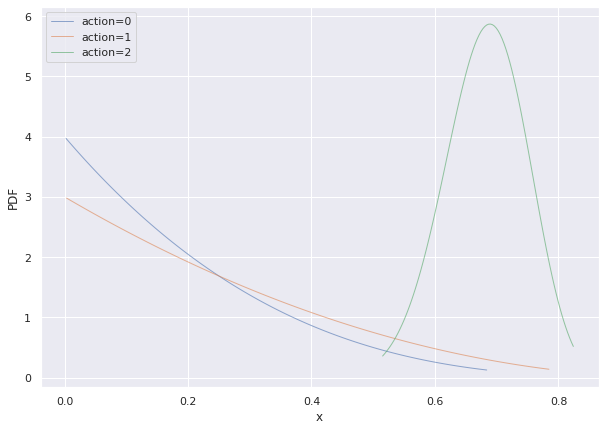

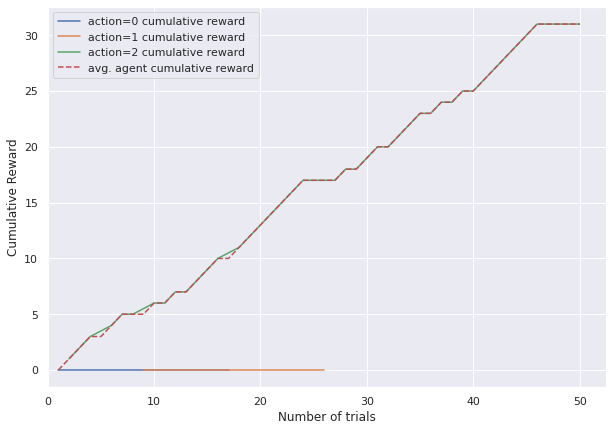

In [11]:
environment = BernoulliEnvironment([0.25, 0.4, 0.67])
step = environment.reset()

agent = BernoulliThompsonSamplingAgent(3)

df_trajectory = run(environment, agent, trials=50)

params = {
    'alpha': np.array(agent._alpha), 
    'beta': np.array(agent._beta)
}

plot_pdf(params, type=0)
plot_cumsum(df_trajectory, show_actions=True)

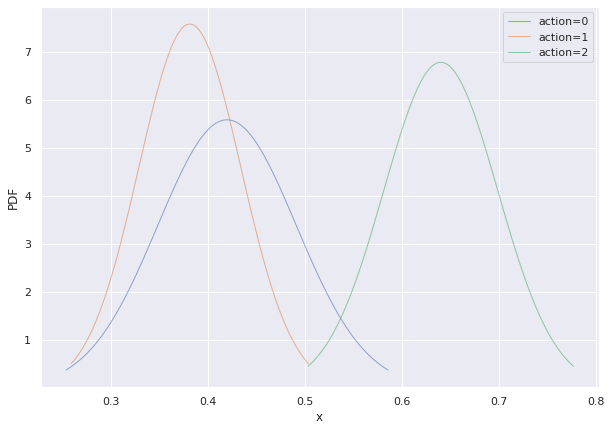

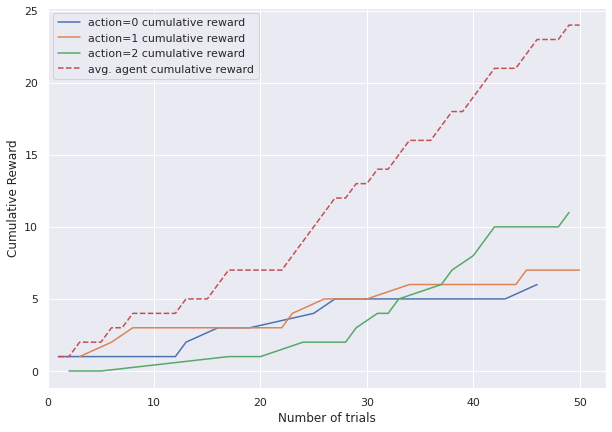

In [12]:
environment = BernoulliEnvironment([0.25, 0.4, 0.67])
step = environment.reset()

agent = GaussianThompsonSamplingAgent(3)

df_trajectory = run(environment, agent, trials=50)

params = {
    'mu': np.array(agent._mu0), 
    'theta': np.array(agent._theta0)
}
plot_pdf(params, type=1)
plot_cumsum(df_trajectory, show_actions=True)

### Epochs

In [13]:
def experiment_bernoulli(epochs: int = 1, trials: int = 10):
  trajectories = []

  environment = BernoulliEnvironment([0.25, 0.4, 0.67])
  params = {
    'alpha': [],
    'beta': []  
  }


  for epoch in trange(epochs):
    step = environment.reset()
    agent = BernoulliThompsonSamplingAgent(3)

    df = run(environment, agent, trials=trials)
    df['epoch'] = epoch + 1
    
    params['alpha'].append(agent._alpha)
    params['beta'].append(agent._beta)

    trajectories.append(df)

  df_trajectory = pd.concat(trajectories, ignore_index=True)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'}), params


def experiment_gaussian(epochs: int = 1, trials: int = 10):
  trajectories = []

  environment = BernoulliEnvironment([0.25, 0.4, 0.67])
  params = {
    'theta': [],
    'mu': []  
  }

  for epoch in trange(epochs):
    step = environment.reset()
    agent = GaussianThompsonSamplingAgent(3)

    df = run(environment, agent, trials=trials)
    df['epoch'] = epoch + 1
    
    params['theta'].append(agent._theta0)
    params['mu'].append(agent._mu0)

    trajectories.append(df)

  df_trajectory = pd.concat(trajectories, ignore_index=True)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'}), params

In [14]:
df_trajectory, params = experiment_bernoulli(epochs=250, trials=1000)

params = {
    'alpha': np.array(params['alpha']).mean(axis=0), 
    'beta': np.array(params['beta']).mean(axis=0)
}

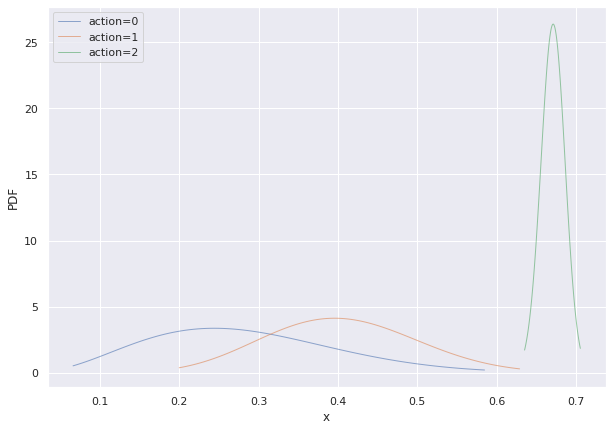

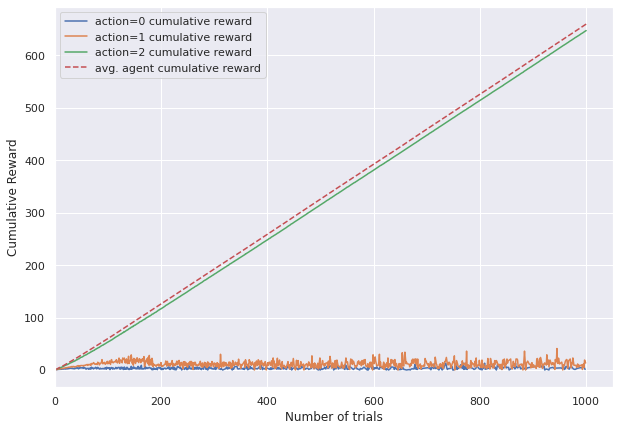

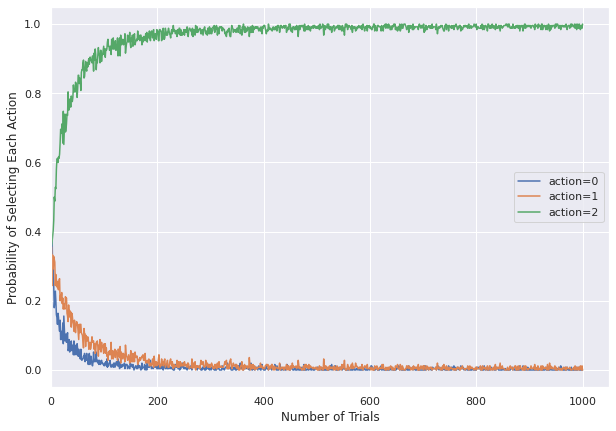

In [15]:
plot_pdf(params, type=0)
plot_cumsum(df_trajectory, show_actions=True)
plot_actions(df_trajectory)

In [16]:
df_trajectory, params = experiment_gaussian(epochs=250, trials=1000)

params = {
    'mu': np.array(params['mu']).mean(axis=0), 
    'theta': np.array(params['theta']).mean(axis=0)
}
print(params)


{'mu': array([0.23227841, 0.3741529 , 0.66992156]), 'theta': array([ 33.5481,  60.9561, 905.4961])}


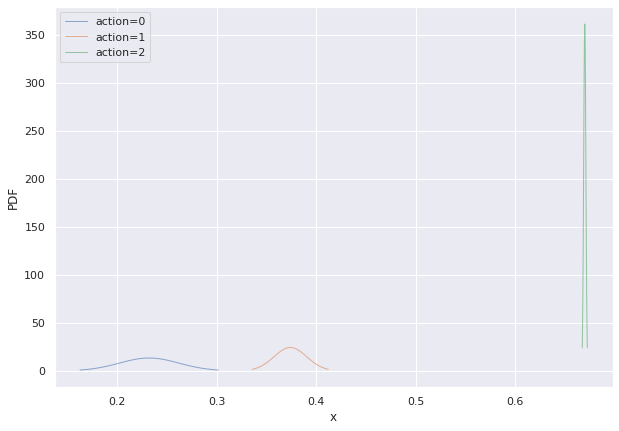

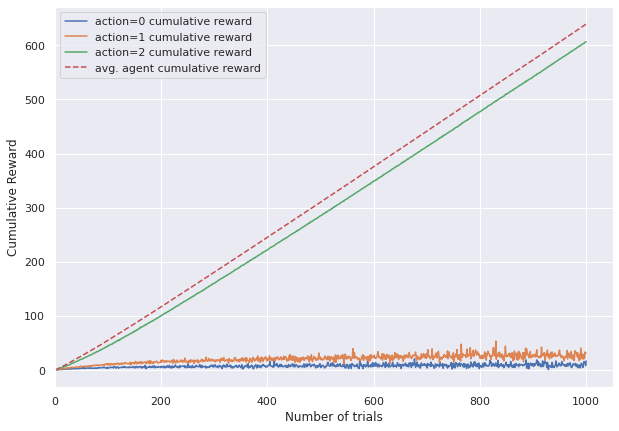

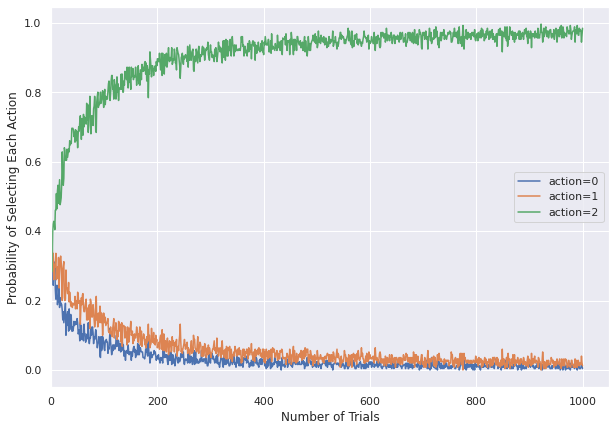

In [17]:
plot_pdf(params, type=1)
plot_cumsum(df_trajectory, show_actions=True)
plot_actions(df_trajectory)